In [1]:
# all this code was borrowed from 
# https://towardsdatascience.com/how-i-used-machine-learning-to-automatically-hand-draw-any-picture-7d024d0de997
import cv2;
from matplotlib import pyplot as plt
import numpy as np
import pyautogui as pg
import kdtree
import operator
from cnc import CNC

class AutoDraw(object):
    def __init__(self, name, blur = 0):
        # Tunable parameters
        self.detail = 1
        self.scale = 7/12
        self.sketch_before = False
        self.with_color = True
        self.num_colors = 10
        self.outline_again = False

        # Load Image. Switch axes to match computer screen
        self.img = cv2.imread(name)
        self.blur = blur
        self.img = np.swapaxes(self.img, 0, 1)
        self.img_shape = self.img.shape

#         self.dim = pg.size()

        self.dim = (100, 100)

        # Scale to draw inside part of screen
        self.startX = ((1 - self.scale) / 2)*self.dim[0] 
        self.startY = ((1 - self.scale) / 2)*self.dim[1] 
        self.dim = (self.dim[0] * self.scale, self.dim[1] * self.scale)

        # fit the picture into this section of the screen
        if self.img_shape[1] > self.img_shape[0]:
            # if it's taller that it is wide, truncate the wide section
            self.dim = (int(self.dim[1] * (self.img_shape[0] / self.img_shape[1])), self.dim[1])
        else:
            # if it's wider than it is tall, truncate the tall section
            self.dim = (self.dim[0], int(self.dim[0] *(self.img_shape[1] / self.img_shape[0])))

        # Get dimension to translate picture. Dimension 1 and 0 are switched due to comp dimensions
        ratio = self.img.shape[0] / self.img.shape[1]
        pseudo_x = int(self.img.shape[1] * self.detail)
        self.pseudoDim = (pseudo_x, int(pseudo_x * ratio))
        
          # Initialize directions for momentum when creating path
        self.maps = {0: (1, 1), 1: (1, 0), 2: (1, -1), 3: (0, -1), 4: (0, 1), 5: (-1, -1), 6: (-1, 0), 7: (-1, 1)}
        self.momentum = 1
        self.curr_delta = self.maps[self.momentum]

        # Create Outline
        self.drawing = self.process_img(self.img)
        plt.imshow(self.drawing)
        plt.show()

    def rescale(self, img, dim):
        resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        return resized

    def translate(self, coord):
        ratio = (coord[0] / self.pseudoDim[1], coord[1] / self.pseudoDim[0]) # this is correct
        deltas = (int(ratio[0] * self.dim[0]), int(ratio[1] * self.dim[1]))
        return self.startX + deltas[0], self.startY + deltas[1]
    
    def process_img(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.blur == 2:
            gray = cv2.GaussianBlur(gray, (9, 9), 0)
            canny = cv2.Canny(gray, 25, 45)
        elif self.blur == 1:
            gray = cv2.GaussianBlur(gray, (3, 3), 0)
            canny = cv2.Canny(gray, 25, 45)
        else:  # no blur
            canny = cv2.Canny(gray, 50, 75)
        canny = self.rescale(canny, self.pseudoDim)
        r, res = cv2.threshold(canny, 50, 255, cv2.THRESH_BINARY_INV)

        return res
    
    def drawOutline(self):
        indices = np.argwhere(self.drawing < 127).tolist()  # get the black colors
        index_tuples = map(tuple, indices)

        self.hashSet = set(index_tuples)
        self.KDTree = kdtree.create(indices)
#         self.KDTree = KDTree(indices)
        self.commands = []
        self.curr_pos = (0, 0)
        point = self.translate(self.curr_pos)
        self.commands.append(point)

#         print('Please change pen to thin and color to black.')
#         input("Press enter once ready")
#         print('')

        # DRAW THE BLACK OUTLINE
        self.createPath()
        return self.commands
#         print(self.commands)
#         input("Ready! Press Enter to draw")
#         print('5 seconds until drawing beings')
#         time.sleep(5)

#         self.execute(self.commands)

    def createPath(self):
        # check for closest point. Go there. Add click down. Change curr. Remove from set and tree. Then, begin
        new_pos = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#         print(self.curr_pos[0)
#         new_pos = tuple(self.KDTree.query(self.curr_pos)[0].data)
        self.commands.append(new_pos)
        self.commands.append("DOWN")
        self.curr_pos = new_pos
        self.KDTree = self.KDTree.remove(list(new_pos))
        self.hashSet.remove(new_pos)

        while len(self.hashSet) > 0:
            prev_direction = self.momentum
            candidate = self.checkMomentum(self.curr_pos)
            if self.isValid(candidate):
                new = tuple(map(operator.add, self.curr_pos, candidate))
                new_pos = self.translate(new)
                if prev_direction == self.momentum and type(self.commands[-1]) != str:  # the direction didn't change
                    self.commands.pop()
                self.commands.append(new_pos)
            else:
                self.commands.append("UP")
                new = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#                 new = tuple(self.KDTree.query(self.curr_pos)[0].data)
                new_pos = self.translate(new)
                self.commands.append(new_pos)
                self.commands.append("DOWN")
            self.curr_pos = new
            self.KDTree = self.KDTree.remove(list(new))
            self.hashSet.remove(new)
#             print('Making path...number points left: ', len(self.hashSet))
        return

    def isValid(self, delta):
        return len(delta) == 2

    def checkMomentum(self, point):
        # Returns best next relative move w.r.t. momentum and if in hashset
        self.curr_delta = self.maps[self.momentum]
        moments = self.maps.values()
        deltas = [d for d in moments if (tuple(map(operator.add, point, d)) in self.hashSet)]
        deltas.sort(key=self.checkDirection, reverse=True)
        if len(deltas) > 0:
            best = deltas[0]
            self.momentum = [item[0] for item in self.maps.items() if item[1] == best][0]
            return best
        return [-1]

    def checkDirection(self, element):
        return self.dot(self.curr_delta, element)

    def dot(self, pt1, pt2):
        pt1 = self.unit(pt1)
        pt2 = self.unit(pt2)
        return pt1[0] * pt2[0] + pt1[1] * pt2[1]

    def unit(self, point):
        norm = (point[0] ** 2 + point[1] ** 2)
        norm = np.sqrt(norm)
        return point[0] / norm, point[1] / norm

G90 
G0 Z5
F3000
G1 Z0
G1 X0.0 Y-0.0
G1 X0.5012531328320802 Y-0.0
G1 X1.0025062656641603 Y-0.0
G1 X1.0025062656641603 Y-0.5016722408026756
G1 X0.5012531328320802 Y-0.5016722408026756
G1 X0.0 Y-0.5016722408026756
G1 X0.0 Y-1.0033444816053512
G1 X0.5012531328320802 Y-1.0033444816053512
G1 X0.5012531328320802 Y-1.5050167224080269
G1 X0.0 Y-1.5050167224080269
G1 X0.0 Y-2.0066889632107023
G1 X0.5012531328320802 Y-2.0066889632107023
G1 X1.0025062656641603 Y-2.0066889632107023
G1 X1.0025062656641603 Y-1.5050167224080269
G1 X1.0025062656641603 Y-1.0033444816053512
G1 X1.5037593984962405 Y-1.0033444816053512
G1 X2.0050125313283207 Y-1.0033444816053512
G1 X2.0050125313283207 Y-1.5050167224080269
G1 X1.5037593984962405 Y-1.5050167224080269
G1 X1.5037593984962405 Y-2.0066889632107023
G1 X2.0050125313283207 Y-2.0066889632107023
G1 X2.506265664160401 Y-2.0066889632107023
G1 X2.506265664160401 Y-1.5050167224080269
G1 X2.506265664160401 Y-1.0033444816053512
G1 X2.506265664160401 Y-0.5016722408026756
G

G1 X13.032581453634084 Y-37.123745819397996
G1 X13.032581453634084 Y-36.62207357859532
G1 X13.032581453634084 Y-36.12040133779264
G1 X13.533834586466165 Y-36.12040133779264
G1 X13.533834586466165 Y-36.62207357859532
G1 X13.533834586466165 Y-37.123745819397996
G1 X14.035087719298245 Y-37.123745819397996
G1 X14.536340852130325 Y-37.123745819397996
G1 X14.536340852130325 Y-36.62207357859532
G1 X14.035087719298245 Y-36.62207357859532
G1 X14.035087719298245 Y-36.12040133779264
G1 X14.536340852130325 Y-36.12040133779264
G1 X15.037593984962406 Y-36.12040133779264
G1 X15.037593984962406 Y-36.62207357859532
G1 X15.037593984962406 Y-37.123745819397996
G1 X15.538847117794486 Y-37.123745819397996
G1 X16.040100250626566 Y-37.123745819397996
G1 X16.541353383458645 Y-37.123745819397996
G1 X16.541353383458645 Y-36.62207357859532
G1 X16.040100250626566 Y-36.62207357859532
G1 X15.538847117794486 Y-36.62207357859532
G1 X15.538847117794486 Y-36.12040133779264
G1 X16.040100250626566 Y-36.12040133779264
G1 

G1 X46.11528822055138 Y-36.12040133779264
G1 X46.11528822055138 Y-36.62207357859532
G1 X46.11528822055138 Y-37.123745819397996
G1 X46.616541353383454 Y-37.123745819397996
G1 X46.616541353383454 Y-36.62207357859532
G1 X46.616541353383454 Y-36.12040133779264
G1 X47.11779448621554 Y-36.12040133779264
G1 X47.11779448621554 Y-36.62207357859532
G1 X47.11779448621554 Y-37.123745819397996
G1 X47.61904761904761 Y-37.123745819397996
G1 X47.61904761904761 Y-36.62207357859532
G1 X47.61904761904761 Y-36.12040133779264
G1 X48.1203007518797 Y-36.12040133779264
G1 X48.1203007518797 Y-36.62207357859532
G1 X48.1203007518797 Y-37.123745819397996
G1 X48.62155388471178 Y-37.123745819397996
G1 X49.122807017543856 Y-37.123745819397996
G1 X49.62406015037594 Y-37.123745819397996
G1 X49.62406015037594 Y-36.62207357859532
G1 X49.122807017543856 Y-36.62207357859532
G1 X48.62155388471178 Y-36.62207357859532
G1 X48.62155388471178 Y-36.12040133779264
G1 X49.122807017543856 Y-36.12040133779264
G1 X49.62406015037594 Y

G1 X38.59649122807017 Y-4.013377926421405
G1 X38.59649122807017 Y-4.51505016722408
G1 X38.095238095238095 Y-4.51505016722408
G1 X37.59398496240601 Y-4.51505016722408
G1 X37.59398496240601 Y-5.016722408026756
G1 X37.59398496240601 Y-5.518394648829432
G1 X37.59398496240601 Y-6.0200668896321075
G1 X38.095238095238095 Y-6.0200668896321075
G1 X38.095238095238095 Y-5.518394648829432
G1 X38.095238095238095 Y-5.016722408026756
G1 X38.59649122807017 Y-5.016722408026756
G1 X38.59649122807017 Y-5.518394648829432
G1 X38.59649122807017 Y-6.0200668896321075
G1 X38.59649122807017 Y-6.521739130434782
G1 X38.095238095238095 Y-6.521739130434782
G1 X37.59398496240601 Y-6.521739130434782
G1 X37.59398496240601 Y-7.023411371237458
G1 X38.095238095238095 Y-7.023411371237458
G1 X38.59649122807017 Y-7.023411371237458
G1 X38.59649122807017 Y-7.525083612040134
G1 X38.095238095238095 Y-7.525083612040134
G1 X37.59398496240601 Y-7.525083612040134
G1 X37.59398496240601 Y-8.02675585284281
G1 X37.59398496240601 Y-8.52

G1 X63.1578947368421 Y-28.093645484949832
G1 X63.1578947368421 Y-28.59531772575251
G1 X63.1578947368421 Y-29.096989966555185
G1 X63.65914786967418 Y-29.096989966555185
G1 X64.16040100250626 Y-29.096989966555185
G1 X64.66165413533834 Y-29.096989966555185
G1 X64.66165413533834 Y-28.59531772575251
G1 X64.16040100250626 Y-28.59531772575251
G1 X63.65914786967418 Y-28.59531772575251
G1 X63.65914786967418 Y-28.093645484949832
G1 X64.16040100250626 Y-28.093645484949832
G1 X64.66165413533834 Y-28.093645484949832
G1 X64.66165413533834 Y-27.591973244147155
G1 X64.66165413533834 Y-27.09030100334448
G1 X64.66165413533834 Y-26.588628762541806
G1 X64.16040100250626 Y-26.588628762541806
G1 X64.16040100250626 Y-27.09030100334448
G1 X64.16040100250626 Y-27.591973244147155
G1 X63.65914786967418 Y-27.591973244147155
G1 X63.65914786967418 Y-27.09030100334448
G1 X63.65914786967418 Y-26.588628762541806
G1 X63.1578947368421 Y-26.588628762541806
G1 X63.1578947368421 Y-27.09030100334448
G1 X63.1578947368421 Y-2

G1 X72.18045112781954 Y-2.0066889632107023
G1 X72.68170426065163 Y-2.0066889632107023
G1 X73.1829573934837 Y-2.0066889632107023
G1 X73.1829573934837 Y-2.508361204013378
G1 X72.68170426065163 Y-2.508361204013378
G1 X72.18045112781954 Y-2.508361204013378
G1 X72.18045112781954 Y-3.0100334448160537
G1 X72.18045112781954 Y-3.511705685618729
G1 X72.18045112781954 Y-4.013377926421405
G1 X72.68170426065163 Y-4.013377926421405
G1 X72.68170426065163 Y-3.511705685618729
G1 X72.68170426065163 Y-3.0100334448160537
G1 X73.1829573934837 Y-3.0100334448160537
G1 X73.1829573934837 Y-3.511705685618729
G1 X73.1829573934837 Y-4.013377926421405
G1 X73.68421052631578 Y-4.013377926421405
G1 X74.18546365914787 Y-4.013377926421405
G1 X74.18546365914787 Y-3.511705685618729
G1 X73.68421052631578 Y-3.511705685618729
G1 X73.68421052631578 Y-3.0100334448160537
G1 X74.18546365914787 Y-3.0100334448160537
G1 X74.68671679197995 Y-3.0100334448160537
G1 X74.68671679197995 Y-3.511705685618729
G1 X74.68671679197995 Y-4.0133

G1 X84.21052631578947 Y-31.60535117056856
G1 X84.71177944862156 Y-31.60535117056856
G1 X85.21303258145363 Y-31.60535117056856
G1 X85.21303258145363 Y-31.103678929765888
G1 X84.71177944862156 Y-31.103678929765888
G1 X84.21052631578947 Y-31.103678929765888
G1 X84.21052631578947 Y-30.60200668896321
G1 X84.71177944862156 Y-30.60200668896321
G1 X85.21303258145363 Y-30.60200668896321
G1 X85.71428571428571 Y-30.60200668896321
G1 X85.71428571428571 Y-31.103678929765888
G1 X85.71428571428571 Y-31.60535117056856
G1 X85.71428571428571 Y-32.10702341137124
G1 X85.71428571428571 Y-32.608695652173914
G1 X85.21303258145363 Y-32.608695652173914
G1 X85.21303258145363 Y-32.10702341137124
G1 X84.71177944862156 Y-32.10702341137124
G1 X84.71177944862156 Y-32.608695652173914
G1 X84.21052631578947 Y-32.608695652173914
G1 X84.21052631578947 Y-32.10702341137124
G1 X83.70927318295739 Y-32.10702341137124
G1 X83.70927318295739 Y-32.608695652173914
G1 X83.70927318295739 Y-33.11036789297659
G1 X83.70927318295739 Y-3

G1 X97.74436090225564 Y-58.69565217391305
G1 X97.24310776942356 Y-58.69565217391305
G1 X97.24310776942356 Y-58.19397993311037
G1 X97.74436090225564 Y-58.19397993311037
G1 X98.24561403508771 Y-58.19397993311037
G1 X98.74686716791979 Y-58.19397993311037
G1 X98.74686716791979 Y-58.69565217391305
G1 X98.74686716791979 Y-59.19732441471572
G1 X99.24812030075188 Y-59.19732441471572
G1 X99.24812030075188 Y-58.69565217391305
G1 X99.24812030075188 Y-58.19397993311037
G1 X99.74937343358395 Y-58.19397993311037
G1 X99.74937343358395 Y-58.69565217391305
G1 X99.74937343358395 Y-59.19732441471572
G1 X99.74937343358395 Y-59.6989966555184
G1 X99.24812030075188 Y-59.6989966555184
G1 X98.74686716791979 Y-59.6989966555184
G1 X98.74686716791979 Y-60.20066889632107
G1 X99.24812030075188 Y-60.20066889632107
G1 X99.74937343358395 Y-60.20066889632107
G1 X99.74937343358395 Y-60.702341137123746
G1 X99.24812030075188 Y-60.702341137123746
G1 X98.74686716791979 Y-60.702341137123746
G1 X98.74686716791979 Y-61.2040133

G1 X79.69924812030075 Y-62.207357859531776
G1 X80.20050125313283 Y-62.207357859531776
G1 X80.20050125313283 Y-61.7056856187291
G1 X80.20050125313283 Y-61.20401337792642
G1 X80.7017543859649 Y-61.20401337792642
G1 X80.7017543859649 Y-61.7056856187291
G1 X80.7017543859649 Y-62.207357859531776
G1 X81.203007518797 Y-62.207357859531776
G1 X81.203007518797 Y-61.7056856187291
G1 X81.203007518797 Y-61.20401337792642
G1 X81.70426065162907 Y-61.20401337792642
G1 X81.70426065162907 Y-61.7056856187291
G1 X81.70426065162907 Y-62.207357859531776
G1 X82.20551378446115 Y-62.207357859531776
G1 X82.70676691729322 Y-62.207357859531776
G1 X83.20802005012531 Y-62.207357859531776
G1 X83.20802005012531 Y-61.7056856187291
G1 X82.70676691729322 Y-61.7056856187291
G1 X82.20551378446115 Y-61.7056856187291
G1 X82.20551378446115 Y-61.20401337792642
G1 X82.70676691729322 Y-61.20401337792642
G1 X83.20802005012531 Y-61.20401337792642
G1 X83.20802005012531 Y-60.702341137123746
G1 X83.20802005012531 Y-60.20066889632107

G1 X54.13533834586466 Y-59.6989966555184
G1 X54.13533834586466 Y-60.20066889632107
G1 X54.63659147869674 Y-60.20066889632107
G1 X55.13784461152882 Y-60.20066889632107
G1 X55.13784461152882 Y-60.702341137123746
G1 X54.63659147869674 Y-60.702341137123746
G1 X54.13533834586466 Y-60.702341137123746
G1 X54.13533834586466 Y-61.20401337792642
G1 X54.13533834586466 Y-61.7056856187291
G1 X54.13533834586466 Y-62.207357859531776
G1 X54.63659147869674 Y-62.207357859531776
G1 X54.63659147869674 Y-61.7056856187291
G1 X54.63659147869674 Y-61.20401337792642
G1 X55.13784461152882 Y-61.20401337792642
G1 X55.13784461152882 Y-61.7056856187291
G1 X55.13784461152882 Y-62.207357859531776
G1 X55.639097744360896 Y-62.207357859531776
G1 X56.14035087719298 Y-62.207357859531776
G1 X56.64160401002506 Y-62.207357859531776
G1 X56.64160401002506 Y-61.7056856187291
G1 X56.14035087719298 Y-61.7056856187291
G1 X55.639097744360896 Y-61.7056856187291
G1 X55.639097744360896 Y-61.20401337792642
G1 X56.14035087719298 Y-61.20

G1 X36.09022556390977 Y-66.72240802675584
G1 X36.59147869674185 Y-66.72240802675584
G1 X37.092731829573935 Y-66.72240802675584
G1 X37.092731829573935 Y-66.22073578595318
G1 X37.092731829573935 Y-65.7190635451505
G1 X37.092731829573935 Y-65.21739130434783
G1 X37.092731829573935 Y-64.71571906354515
G1 X36.59147869674185 Y-64.71571906354515
G1 X36.59147869674185 Y-65.21739130434783
G1 X36.09022556390977 Y-65.21739130434783
G1 X36.09022556390977 Y-64.71571906354515
G1 X35.58897243107769 Y-64.71571906354515
G1 X35.58897243107769 Y-65.21739130434783
G1 X35.08771929824561 Y-65.21739130434783
G1 X35.08771929824561 Y-64.71571906354515
G1 X35.08771929824561 Y-64.21404682274247
G1 X35.58897243107769 Y-64.21404682274247
G1 X36.09022556390977 Y-64.21404682274247
G1 X36.09022556390977 Y-63.7123745819398
G1 X35.58897243107769 Y-63.7123745819398
G1 X35.08771929824561 Y-63.7123745819398
G1 X35.08771929824561 Y-63.21070234113712
G1 X35.58897243107769 Y-63.21070234113712
G1 X36.09022556390977 Y-63.210702

G1 X32.581453634085214 Y-37.625418060200666
G1 X32.08020050125313 Y-37.625418060200666
G1 X32.08020050125313 Y-38.12709030100334
G1 X32.08020050125313 Y-38.62876254180602
G1 X31.57894736842105 Y-38.62876254180602
G1 X31.57894736842105 Y-38.12709030100334
G1 X31.57894736842105 Y-37.625418060200666
G1 X31.07769423558897 Y-37.625418060200666
G1 X31.07769423558897 Y-38.12709030100334
G1 X31.07769423558897 Y-38.62876254180602
G1 X30.576441102756892 Y-38.62876254180602
G1 X30.576441102756892 Y-38.12709030100334
G1 X30.576441102756892 Y-37.625418060200666
G1 X30.075187969924812 Y-37.625418060200666
G1 X29.57393483709273 Y-37.625418060200666
G1 X29.07268170426065 Y-37.625418060200666
G1 X29.07268170426065 Y-38.12709030100334
G1 X29.57393483709273 Y-38.12709030100334
G1 X30.075187969924812 Y-38.12709030100334
G1 X30.075187969924812 Y-38.62876254180602
G1 X29.57393483709273 Y-38.62876254180602
G1 X29.07268170426065 Y-38.62876254180602
G1 X29.07268170426065 Y-39.130434782608695
G1 X29.07268170426

G1 X8.020050125313283 Y-48.66220735785953
G1 X8.521303258145362 Y-48.66220735785953
G1 X8.521303258145362 Y-48.16053511705686
G1 X8.521303258145362 Y-47.65886287625418
G1 X8.020050125313283 Y-47.65886287625418
G1 X7.518796992481203 Y-47.65886287625418
G1 X7.518796992481203 Y-47.15719063545151
G1 X8.020050125313283 Y-47.15719063545151
G1 X8.521303258145362 Y-47.15719063545151
G1 X9.022556390977442 Y-47.15719063545151
G1 X9.523809523809524 Y-47.15719063545151
G1 X9.523809523809524 Y-47.65886287625418
G1 X9.022556390977442 Y-47.65886287625418
G1 X9.022556390977442 Y-48.16053511705686
G1 X9.022556390977442 Y-48.66220735785953
G1 X9.523809523809524 Y-48.66220735785953
G1 X9.523809523809524 Y-48.16053511705686
G1 X10.025062656641603 Y-48.16053511705686
G1 X10.025062656641603 Y-48.66220735785953
G1 X10.526315789473683 Y-48.66220735785953
G1 X10.526315789473683 Y-48.16053511705686
G1 X10.526315789473683 Y-47.65886287625418
G1 X10.025062656641603 Y-47.65886287625418
G1 X10.025062656641603 Y-47.

G1 X6.015037593984962 Y-74.24749163879599
G1 X6.015037593984962 Y-74.74916387959867
G1 X5.513784461152882 Y-74.74916387959867
G1 X5.012531328320802 Y-74.74916387959867
G1 X4.511278195488721 Y-74.74916387959867
G1 X4.010025062656641 Y-74.74916387959867
G1 X4.010025062656641 Y-74.24749163879599
G1 X4.511278195488721 Y-74.24749163879599
G1 X4.511278195488721 Y-73.74581939799332
G1 X4.010025062656641 Y-73.74581939799332
G1 X3.508771929824561 Y-73.74581939799332
G1 X3.007518796992481 Y-73.74581939799332
G1 X3.007518796992481 Y-74.24749163879599
G1 X3.508771929824561 Y-74.24749163879599
G1 X3.508771929824561 Y-74.74916387959867
G1 X3.007518796992481 Y-74.74916387959867
G1 X2.506265664160401 Y-74.74916387959867
G1 X2.0050125313283207 Y-74.74916387959867
G1 X1.5037593984962405 Y-74.74916387959867
G1 X1.5037593984962405 Y-74.24749163879599
G1 X2.0050125313283207 Y-74.24749163879599
G1 X2.506265664160401 Y-74.24749163879599
G1 X2.506265664160401 Y-73.74581939799332
G1 X2.0050125313283207 Y-73.74

G1 X32.581453634085214 Y-78.26086956521739
G1 X32.581453634085214 Y-77.75919732441471
G1 X32.08020050125313 Y-77.75919732441471
G1 X31.57894736842105 Y-77.75919732441471
G1 X31.07769423558897 Y-77.75919732441471
G1 X31.07769423558897 Y-78.26086956521739
G1 X31.57894736842105 Y-78.26086956521739
G1 X32.08020050125313 Y-78.26086956521739
G1 X32.08020050125313 Y-78.76254180602007
G1 X31.57894736842105 Y-78.76254180602007
G1 X31.07769423558897 Y-78.76254180602007
G1 X31.07769423558897 Y-79.26421404682274
G1 X31.57894736842105 Y-79.26421404682274
G1 X31.57894736842105 Y-79.76588628762542
G1 X31.07769423558897 Y-79.76588628762542
G1 X31.07769423558897 Y-80.2675585284281
G1 X31.57894736842105 Y-80.2675585284281
G1 X31.57894736842105 Y-80.76923076923076
G1 X31.07769423558897 Y-80.76923076923076
G1 X31.07769423558897 Y-81.27090301003344
G1 X31.57894736842105 Y-81.27090301003344
G1 X32.08020050125313 Y-81.27090301003344
G1 X32.08020050125313 Y-80.76923076923076
G1 X32.08020050125313 Y-80.2675585

G1 X49.122807017543856 Y-111.37123745819397
G1 X49.122807017543856 Y-111.87290969899665
G1 X49.122807017543856 Y-112.37458193979933
G1 X48.62155388471178 Y-112.37458193979933
G1 X48.62155388471178 Y-111.87290969899665
G1 X48.62155388471178 Y-111.37123745819397
G1 X48.62155388471178 Y-110.8695652173913
G1 X49.122807017543856 Y-110.8695652173913
G1 X49.122807017543856 Y-110.36789297658862
G1 X48.62155388471178 Y-110.36789297658862
G1 X48.1203007518797 Y-110.36789297658862
G1 X47.61904761904761 Y-110.36789297658862
G1 X47.61904761904761 Y-110.8695652173913
G1 X48.1203007518797 Y-110.8695652173913
G1 X48.1203007518797 Y-111.37123745819397
G1 X48.1203007518797 Y-111.87290969899665
G1 X48.1203007518797 Y-112.37458193979933
G1 X47.61904761904761 Y-112.37458193979933
G1 X47.61904761904761 Y-111.87290969899665
G1 X47.61904761904761 Y-111.37123745819397
G1 X47.11779448621554 Y-111.37123745819397
G1 X47.11779448621554 Y-111.87290969899665
G1 X47.11779448621554 Y-112.37458193979933
G1 X46.61654135

G1 X14.035087719298245 Y-97.82608695652173
G1 X14.035087719298245 Y-97.32441471571906
G1 X13.533834586466165 Y-97.32441471571906
G1 X13.032581453634084 Y-97.32441471571906
G1 X12.531328320802004 Y-97.32441471571906
G1 X12.531328320802004 Y-97.82608695652173
G1 X13.032581453634084 Y-97.82608695652173
G1 X13.533834586466165 Y-97.82608695652173
G1 X13.533834586466165 Y-98.32775919732441
G1 X13.032581453634084 Y-98.32775919732441
G1 X12.531328320802004 Y-98.32775919732441
G1 X12.531328320802004 Y-98.82943143812709
G1 X13.032581453634084 Y-98.82943143812709
G1 X13.533834586466165 Y-98.82943143812709
G1 X13.533834586466165 Y-99.33110367892976
G1 X13.032581453634084 Y-99.33110367892976
G1 X12.531328320802004 Y-99.33110367892976
G1 X12.531328320802004 Y-99.83277591973244
G1 X13.032581453634084 Y-99.83277591973244
G1 X13.032581453634084 Y-100.33444816053512
G1 X12.531328320802004 Y-100.33444816053512
G1 X12.531328320802004 Y-100.8361204013378
G1 X13.032581453634084 Y-100.8361204013378
G1 X13.53

G1 X13.533834586466165 Y-137.4581939799331
G1 X13.533834586466165 Y-136.95652173913044
G1 X13.533834586466165 Y-136.45484949832775
G1 X13.533834586466165 Y-135.95317725752508
G1 X13.533834586466165 Y-135.4515050167224
G1 X14.035087719298245 Y-135.4515050167224
G1 X14.035087719298245 Y-135.95317725752508
G1 X14.536340852130325 Y-135.95317725752508
G1 X14.536340852130325 Y-135.4515050167224
G1 X14.536340852130325 Y-134.94983277591973
G1 X14.536340852130325 Y-134.44816053511704
G1 X14.035087719298245 Y-134.44816053511704
G1 X14.035087719298245 Y-134.94983277591973
G1 X13.533834586466165 Y-134.94983277591973
G1 X13.533834586466165 Y-134.44816053511704
G1 X13.032581453634084 Y-134.44816053511704
G1 X13.032581453634084 Y-134.94983277591973
G1 X12.531328320802004 Y-134.94983277591973
G1 X12.531328320802004 Y-134.44816053511704
G1 X12.030075187969924 Y-134.44816053511704
G1 X12.030075187969924 Y-134.94983277591973
G1 X11.528822055137844 Y-134.94983277591973
G1 X11.528822055137844 Y-134.4481605

G1 X28.07017543859649 Y-139.9665551839465
G1 X28.07017543859649 Y-140.46822742474916
G1 X27.56892230576441 Y-140.46822742474916
G1 X27.56892230576441 Y-140.96989966555185
G1 X28.07017543859649 Y-140.96989966555185
G1 X28.07017543859649 Y-141.4715719063545
G1 X28.07017543859649 Y-141.9732441471572
G1 X28.07017543859649 Y-142.47491638795987
G1 X27.56892230576441 Y-142.47491638795987
G1 X27.56892230576441 Y-141.9732441471572
G1 X27.56892230576441 Y-141.4715719063545
G1 X27.06766917293233 Y-141.4715719063545
G1 X26.56641604010025 Y-141.4715719063545
G1 X26.065162907268167 Y-141.4715719063545
G1 X26.065162907268167 Y-141.9732441471572
G1 X26.56641604010025 Y-141.9732441471572
G1 X27.06766917293233 Y-141.9732441471572
G1 X27.06766917293233 Y-142.47491638795987
G1 X26.56641604010025 Y-142.47491638795987
G1 X26.065162907268167 Y-142.47491638795987
G1 X26.065162907268167 Y-142.97658862876256
G1 X26.56641604010025 Y-142.97658862876256
G1 X26.56641604010025 Y-143.47826086956522
G1 X26.06516290726

G1 X32.08020050125313 Y-123.91304347826087
G1 X31.57894736842105 Y-123.91304347826087
G1 X31.57894736842105 Y-123.4113712374582
G1 X31.57894736842105 Y-122.90969899665552
G1 X31.57894736842105 Y-122.40802675585284
G1 X31.57894736842105 Y-121.90635451505017
G1 X32.08020050125313 Y-121.90635451505017
G1 X32.08020050125313 Y-122.40802675585284
G1 X32.581453634085214 Y-122.40802675585284
G1 X32.581453634085214 Y-121.90635451505017
G1 X33.08270676691729 Y-121.90635451505017
G1 X33.08270676691729 Y-122.40802675585284
G1 X33.583959899749374 Y-122.40802675585284
G1 X33.583959899749374 Y-121.90635451505017
G1 X33.583959899749374 Y-121.40468227424749
G1 X33.583959899749374 Y-120.90301003344482
G1 X33.583959899749374 Y-120.40133779264214
G1 X33.08270676691729 Y-120.40133779264214
G1 X33.08270676691729 Y-120.90301003344482
G1 X33.08270676691729 Y-121.40468227424749
G1 X32.581453634085214 Y-121.40468227424749
G1 X32.581453634085214 Y-120.90301003344482
G1 X32.581453634085214 Y-120.40133779264214
G1

G1 X36.09022556390977 Y-139.4648829431438
G1 X36.09022556390977 Y-139.9665551839465
G1 X36.09022556390977 Y-140.46822742474916
G1 X35.58897243107769 Y-140.46822742474916
G1 X35.58897243107769 Y-139.9665551839465
G1 X35.58897243107769 Y-139.4648829431438
G1 X35.58897243107769 Y-138.96321070234114
G1 X35.58897243107769 Y-138.46153846153848
G1 X35.58897243107769 Y-137.9598662207358
G1 X36.09022556390977 Y-137.9598662207358
G1 X36.09022556390977 Y-138.46153846153848
G1 X36.09022556390977 Y-138.96321070234114
G1 X36.59147869674185 Y-138.96321070234114
G1 X37.092731829573935 Y-138.96321070234114
G1 X37.59398496240601 Y-138.96321070234114
G1 X37.59398496240601 Y-138.46153846153848
G1 X37.092731829573935 Y-138.46153846153848
G1 X36.59147869674185 Y-138.46153846153848
G1 X36.59147869674185 Y-137.9598662207358
G1 X37.092731829573935 Y-137.9598662207358
G1 X37.59398496240601 Y-137.9598662207358
G1 X38.095238095238095 Y-137.9598662207358
G1 X38.095238095238095 Y-138.46153846153848
G1 X38.095238095

G1 X58.1453634085213 Y-120.90301003344482
G1 X58.1453634085213 Y-121.40468227424749
G1 X57.64411027568922 Y-121.40468227424749
G1 X57.64411027568922 Y-120.90301003344482
G1 X57.64411027568922 Y-120.40133779264214
G1 X57.14285714285714 Y-120.40133779264214
G1 X56.64160401002506 Y-120.40133779264214
G1 X56.14035087719298 Y-120.40133779264214
G1 X56.14035087719298 Y-120.90301003344482
G1 X56.64160401002506 Y-120.90301003344482
G1 X57.14285714285714 Y-120.90301003344482
G1 X57.14285714285714 Y-121.40468227424749
G1 X56.64160401002506 Y-121.40468227424749
G1 X56.14035087719298 Y-121.40468227424749
G1 X56.14035087719298 Y-121.90635451505017
G1 X56.14035087719298 Y-122.40802675585284
G1 X56.64160401002506 Y-122.40802675585284
G1 X56.64160401002506 Y-121.90635451505017
G1 X57.14285714285714 Y-121.90635451505017
G1 X57.14285714285714 Y-122.40802675585284
G1 X57.14285714285714 Y-122.90969899665552
G1 X57.14285714285714 Y-123.4113712374582
G1 X56.64160401002506 Y-123.4113712374582
G1 X56.64160401

G1 X72.18045112781954 Y-142.47491638795987
G1 X72.18045112781954 Y-142.97658862876256
G1 X71.67919799498746 Y-142.97658862876256
G1 X71.67919799498746 Y-142.47491638795987
G1 X71.17794486215539 Y-142.47491638795987
G1 X71.17794486215539 Y-142.97658862876256
G1 X71.17794486215539 Y-143.47826086956522
G1 X71.17794486215539 Y-143.9799331103679
G1 X71.67919799498746 Y-143.9799331103679
G1 X71.67919799498746 Y-143.47826086956522
G1 X72.18045112781954 Y-143.47826086956522
G1 X72.18045112781954 Y-143.9799331103679
G1 X72.18045112781954 Y-144.48160535117057
G1 X71.67919799498746 Y-144.48160535117057
G1 X71.67919799498746 Y-144.98327759197323
G1 X72.18045112781954 Y-144.98327759197323
G1 X72.18045112781954 Y-145.48494983277592
G1 X71.67919799498746 Y-145.48494983277592
G1 X71.17794486215539 Y-145.48494983277592
G1 X71.17794486215539 Y-144.98327759197323
G1 X71.17794486215539 Y-144.48160535117057
G1 X70.67669172932331 Y-144.48160535117057
G1 X70.17543859649122 Y-144.48160535117057
G1 X70.1754385

G1 X88.7218045112782 Y-127.92642140468227
G1 X88.7218045112782 Y-127.4247491638796
G1 X88.22055137844612 Y-127.4247491638796
G1 X87.71929824561403 Y-127.4247491638796
G1 X87.71929824561403 Y-126.92307692307692
G1 X88.22055137844612 Y-126.92307692307692
G1 X88.7218045112782 Y-126.92307692307692
G1 X88.7218045112782 Y-126.42140468227424
G1 X88.7218045112782 Y-125.91973244147157
G1 X88.7218045112782 Y-125.41806020066889
G1 X88.22055137844612 Y-125.41806020066889
G1 X88.22055137844612 Y-125.91973244147157
G1 X88.22055137844612 Y-126.42140468227424
G1 X87.71929824561403 Y-126.42140468227424
G1 X87.71929824561403 Y-125.91973244147157
G1 X87.71929824561403 Y-125.41806020066889
G1 X87.21804511278195 Y-125.41806020066889
G1 X87.21804511278195 Y-125.91973244147157
G1 X87.21804511278195 Y-126.42140468227424
G1 X86.71679197994987 Y-126.42140468227424
G1 X86.71679197994987 Y-125.91973244147157
G1 X86.71679197994987 Y-125.41806020066889
G1 X86.21553884711778 Y-125.41806020066889
G1 X85.7142857142857

G1 X80.20050125313283 Y-100.8361204013378
G1 X80.20050125313283 Y-101.33779264214047
G1 X80.7017543859649 Y-101.33779264214047
G1 X80.7017543859649 Y-100.8361204013378
G1 X81.203007518797 Y-100.8361204013378
G1 X81.203007518797 Y-101.33779264214047
G1 X81.203007518797 Y-101.83946488294315
G1 X80.7017543859649 Y-101.83946488294315
G1 X80.20050125313283 Y-101.83946488294315
G1 X80.20050125313283 Y-102.34113712374582
G1 X80.7017543859649 Y-102.34113712374582
G1 X81.203007518797 Y-102.34113712374582
G1 X81.203007518797 Y-102.84280936454849
G1 X80.7017543859649 Y-102.84280936454849
G1 X80.20050125313283 Y-102.84280936454849
G1 X79.69924812030075 Y-102.84280936454849
G1 X79.19799498746866 Y-102.84280936454849
G1 X79.19799498746866 Y-102.34113712374582
G1 X79.69924812030075 Y-102.34113712374582
G1 X79.69924812030075 Y-101.83946488294315
G1 X79.19799498746866 Y-101.83946488294315
G1 X78.69674185463658 Y-101.83946488294315
G1 X78.19548872180451 Y-101.83946488294315
G1 X78.19548872180451 Y-102.3

G1 X50.6265664160401 Y-93.81270903010034
G1 X50.6265664160401 Y-93.31103678929766
G1 X50.6265664160401 Y-92.80936454849498
G1 X50.6265664160401 Y-92.3076923076923
G1 X51.127819548872175 Y-92.3076923076923
G1 X51.127819548872175 Y-92.80936454849498
G1 X51.127819548872175 Y-93.31103678929766
G1 X51.62907268170426 Y-93.31103678929766
G1 X52.130325814536334 Y-93.31103678929766
G1 X52.130325814536334 Y-92.80936454849498
G1 X51.62907268170426 Y-92.80936454849498
G1 X51.62907268170426 Y-92.3076923076923
G1 X52.130325814536334 Y-92.3076923076923
G1 X52.130325814536334 Y-91.80602006688964
G1 X51.62907268170426 Y-91.80602006688964
G1 X51.62907268170426 Y-91.30434782608697
G1 X52.130325814536334 Y-91.30434782608697
G1 X52.130325814536334 Y-90.80267558528429
G1 X51.62907268170426 Y-90.80267558528429
G1 X51.127819548872175 Y-90.80267558528429
G1 X51.127819548872175 Y-91.30434782608697
G1 X51.127819548872175 Y-91.80602006688964
G1 X50.6265664160401 Y-91.80602006688964
G1 X50.6265664160401 Y-91.30434

G1 X79.69924812030075 Y-87.29096989966554
G1 X79.69924812030075 Y-86.78929765886286
G1 X79.19799498746866 Y-86.78929765886286
G1 X78.69674185463658 Y-86.78929765886286
G1 X78.19548872180451 Y-86.78929765886286
G1 X78.19548872180451 Y-87.29096989966554
G1 X78.69674185463658 Y-87.29096989966554
G1 X78.69674185463658 Y-87.79264214046823
G1 X78.19548872180451 Y-87.79264214046823
G1 X78.19548872180451 Y-88.29431438127091
G1 X78.69674185463658 Y-88.29431438127091
G1 X78.69674185463658 Y-88.79598662207358
G1 X78.19548872180451 Y-88.79598662207358
G1 X77.69423558897243 Y-88.79598662207358
G1 X77.19298245614034 Y-88.79598662207358
G1 X76.69172932330827 Y-88.79598662207358
G1 X76.69172932330827 Y-88.29431438127091
G1 X77.19298245614034 Y-88.29431438127091
G1 X77.69423558897243 Y-88.29431438127091
G1 X77.69423558897243 Y-87.79264214046823
G1 X77.19298245614034 Y-87.79264214046823
G1 X77.19298245614034 Y-87.29096989966554
G1 X77.69423558897243 Y-87.29096989966554
G1 X77.69423558897243 Y-86.7892976

G1 X111.77944862155388 Y-86.78929765886286
G1 X112.28070175438596 Y-86.78929765886286
G1 X112.28070175438596 Y-86.28762541806019
G1 X112.28070175438596 Y-85.78595317725751
G1 X112.28070175438596 Y-85.28428093645485
G1 X111.77944862155388 Y-85.28428093645485
G1 X111.27819548872179 Y-85.28428093645485
G1 X111.27819548872179 Y-84.78260869565217
G1 X111.77944862155388 Y-84.78260869565217
G1 X112.28070175438596 Y-84.78260869565217
G1 X112.78195488721805 Y-84.78260869565217
G1 X113.28320802005013 Y-84.78260869565217
G1 X113.78446115288222 Y-84.78260869565217
G1 X113.78446115288222 Y-85.28428093645485
G1 X113.28320802005013 Y-85.28428093645485
G1 X112.78195488721805 Y-85.28428093645485
G1 X112.78195488721805 Y-85.78595317725751
G1 X113.28320802005013 Y-85.78595317725751
G1 X113.28320802005013 Y-86.28762541806019
G1 X112.78195488721805 Y-86.28762541806019
G1 X112.78195488721805 Y-86.78929765886286
G1 X113.28320802005013 Y-86.78929765886286
G1 X113.78446115288222 Y-86.78929765886286
G1 X113.784

G1 X147.36842105263156 Y-81.27090301003344
G1 X147.86967418546365 Y-81.27090301003344
G1 X147.86967418546365 Y-80.76923076923076
G1 X147.86967418546365 Y-80.2675585284281
G1 X147.36842105263156 Y-80.2675585284281
G1 X146.8671679197995 Y-80.2675585284281
G1 X146.8671679197995 Y-79.76588628762542
G1 X146.8671679197995 Y-79.26421404682274
G1 X147.36842105263156 Y-79.26421404682274
G1 X147.36842105263156 Y-79.76588628762542
G1 X147.86967418546365 Y-79.76588628762542
G1 X147.86967418546365 Y-79.26421404682274
G1 X147.86967418546365 Y-78.76254180602007
G1 X147.36842105263156 Y-78.76254180602007
G1 X147.36842105263156 Y-78.26086956521739
G1 X147.86967418546365 Y-78.26086956521739
G1 X147.86967418546365 Y-77.75919732441471
G1 X147.36842105263156 Y-77.75919732441471
G1 X146.8671679197995 Y-77.75919732441471
G1 X146.3659147869674 Y-77.75919732441471
G1 X146.3659147869674 Y-78.26086956521739
G1 X146.8671679197995 Y-78.26086956521739
G1 X146.8671679197995 Y-78.76254180602007
G1 X146.3659147869674 

G1 X131.8295739348371 Y-110.36789297658862
G1 X131.328320802005 Y-110.36789297658862
G1 X130.82706766917295 Y-110.36789297658862
G1 X130.82706766917295 Y-110.8695652173913
G1 X131.328320802005 Y-110.8695652173913
G1 X131.328320802005 Y-111.37123745819397
G1 X131.328320802005 Y-111.87290969899665
G1 X131.328320802005 Y-112.37458193979933
G1 X130.82706766917295 Y-112.37458193979933
G1 X130.82706766917295 Y-111.87290969899665
G1 X130.82706766917295 Y-111.37123745819397
G1 X130.32581453634086 Y-111.37123745819397
G1 X130.32581453634086 Y-111.87290969899665
G1 X130.32581453634086 Y-112.37458193979933
G1 X129.82456140350877 Y-112.37458193979933
G1 X129.82456140350877 Y-111.87290969899665
G1 X129.82456140350877 Y-111.37123745819397
G1 X129.82456140350877 Y-110.8695652173913
G1 X130.32581453634086 Y-110.8695652173913
G1 X130.32581453634086 Y-110.36789297658862
G1 X129.82456140350877 Y-110.36789297658862
G1 X129.82456140350877 Y-109.86622073578594
G1 X129.82456140350877 Y-109.36454849498327
G1 

G1 X109.77443609022556 Y-123.4113712374582
G1 X109.77443609022556 Y-122.90969899665552
G1 X109.77443609022556 Y-122.40802675585284
G1 X109.77443609022556 Y-121.90635451505017
G1 X110.27568922305764 Y-121.90635451505017
G1 X110.77694235588973 Y-121.90635451505017
G1 X110.77694235588973 Y-121.40468227424749
G1 X110.27568922305764 Y-121.40468227424749
G1 X109.77443609022556 Y-121.40468227424749
G1 X109.77443609022556 Y-120.90301003344482
G1 X110.27568922305764 Y-120.90301003344482
G1 X110.77694235588973 Y-120.90301003344482
G1 X110.77694235588973 Y-120.40133779264214
G1 X110.77694235588973 Y-119.89966555183946
G1 X110.27568922305764 Y-119.89966555183946
G1 X110.27568922305764 Y-120.40133779264214
G1 X109.77443609022556 Y-120.40133779264214
G1 X109.77443609022556 Y-119.89966555183946
G1 X109.77443609022556 Y-119.3979933110368
G1 X109.77443609022556 Y-118.89632107023412
G1 X110.27568922305764 Y-118.89632107023412
G1 X110.27568922305764 Y-119.3979933110368
G1 X110.77694235588973 Y-119.397993

G1 X118.29573934837092 Y-142.97658862876256
G1 X118.796992481203 Y-142.97658862876256
G1 X118.796992481203 Y-143.47826086956522
G1 X118.29573934837092 Y-143.47826086956522
G1 X118.29573934837092 Y-143.9799331103679
G1 X118.796992481203 Y-143.9799331103679
G1 X118.796992481203 Y-144.48160535117057
G1 X118.29573934837092 Y-144.48160535117057
G1 X118.29573934837092 Y-144.98327759197323
G1 X118.796992481203 Y-144.98327759197323
G1 X119.29824561403508 Y-144.98327759197323
G1 X119.29824561403508 Y-144.48160535117057
G1 X119.29824561403508 Y-143.9799331103679
G1 X119.29824561403508 Y-143.47826086956522
G1 X119.29824561403508 Y-142.97658862876256
G1 X119.79949874686717 Y-142.97658862876256
G1 X120.30075187969925 Y-142.97658862876256
G1 X120.30075187969925 Y-143.47826086956522
G1 X119.79949874686717 Y-143.47826086956522
G1 X119.79949874686717 Y-143.9799331103679
G1 X120.30075187969925 Y-143.9799331103679
G1 X120.30075187969925 Y-144.48160535117057
G1 X119.79949874686717 Y-144.48160535117057
G1 

G1 X132.33082706766916 Y-123.91304347826087
G1 X131.8295739348371 Y-123.91304347826087
G1 X131.8295739348371 Y-123.4113712374582
G1 X131.8295739348371 Y-122.90969899665552
G1 X131.8295739348371 Y-122.40802675585284
G1 X131.8295739348371 Y-121.90635451505017
G1 X132.33082706766916 Y-121.90635451505017
G1 X132.33082706766916 Y-122.40802675585284
G1 X132.83208020050125 Y-122.40802675585284
G1 X132.83208020050125 Y-121.90635451505017
G1 X133.33333333333331 Y-121.90635451505017
G1 X133.33333333333331 Y-122.40802675585284
G1 X133.8345864661654 Y-122.40802675585284
G1 X133.8345864661654 Y-121.90635451505017
G1 X133.8345864661654 Y-121.40468227424749
G1 X133.8345864661654 Y-120.90301003344482
G1 X133.8345864661654 Y-120.40133779264214
G1 X133.33333333333331 Y-120.40133779264214
G1 X133.33333333333331 Y-120.90301003344482
G1 X133.33333333333331 Y-121.40468227424749
G1 X132.83208020050125 Y-121.40468227424749
G1 X132.83208020050125 Y-120.90301003344482
G1 X132.83208020050125 Y-120.40133779264214

G1 X141.8546365914787 Y-146.98996655518394
G1 X141.8546365914787 Y-146.48829431438128
G1 X141.8546365914787 Y-145.9866220735786
G1 X142.35588972431077 Y-145.9866220735786
G1 X142.35588972431077 Y-146.48829431438128
G1 X142.35588972431077 Y-146.98996655518394
G1 X142.85714285714286 Y-146.98996655518394
G1 X142.85714285714286 Y-146.48829431438128
G1 X142.85714285714286 Y-145.9866220735786
G1 X143.35839598997492 Y-145.9866220735786
G1 X143.35839598997492 Y-146.48829431438128
G1 X143.35839598997492 Y-146.98996655518394
G1 X143.35839598997492 Y-147.49163879598663
G1 X143.35839598997492 Y-147.9933110367893
G1 X143.35839598997492 Y-148.49498327759198
G1 X142.85714285714286 Y-148.49498327759198
G1 X142.85714285714286 Y-147.9933110367893
G1 X142.85714285714286 Y-147.49163879598663
G1 X142.35588972431077 Y-147.49163879598663
G1 X141.8546365914787 Y-147.49163879598663
G1 X141.35338345864662 Y-147.49163879598663
G1 X141.35338345864662 Y-147.9933110367893
G1 X141.8546365914787 Y-147.9933110367893
G

G1 X150.87719298245614 Y-128.42809364548495
G1 X150.87719298245614 Y-127.92642140468227
G1 X151.3784461152882 Y-127.92642140468227
G1 X151.8796992481203 Y-127.92642140468227
G1 X151.8796992481203 Y-127.4247491638796
G1 X151.3784461152882 Y-127.4247491638796
G1 X150.87719298245614 Y-127.4247491638796
G1 X150.87719298245614 Y-126.92307692307692
G1 X151.3784461152882 Y-126.92307692307692
G1 X151.8796992481203 Y-126.92307692307692
G1 X151.8796992481203 Y-126.42140468227424
G1 X151.8796992481203 Y-125.91973244147157
G1 X151.8796992481203 Y-125.41806020066889
G1 X151.3784461152882 Y-125.41806020066889
G1 X151.3784461152882 Y-125.91973244147157
G1 X151.3784461152882 Y-126.42140468227424
G1 X150.87719298245614 Y-126.42140468227424
G1 X150.87719298245614 Y-125.91973244147157
G1 X150.87719298245614 Y-125.41806020066889
G1 X150.87719298245614 Y-124.91638795986623
G1 X150.87719298245614 Y-124.41471571906355
G1 X151.3784461152882 Y-124.41471571906355
G1 X151.3784461152882 Y-124.91638795986623
G1 X1

G1 X173.93483709273184 Y-131.438127090301
G1 X173.93483709273184 Y-130.93645484949832
G1 X173.93483709273184 Y-130.43478260869566
G1 X173.43358395989975 Y-130.43478260869566
G1 X173.43358395989975 Y-130.93645484949832
G1 X173.43358395989975 Y-131.438127090301
G1 X172.93233082706766 Y-131.438127090301
G1 X172.93233082706766 Y-130.93645484949832
G1 X172.93233082706766 Y-130.43478260869566
G1 X172.93233082706766 Y-129.93311036789297
G1 X173.43358395989975 Y-129.93311036789297
G1 X173.93483709273184 Y-129.93311036789297
G1 X173.93483709273184 Y-129.4314381270903
G1 X173.43358395989975 Y-129.4314381270903
G1 X172.93233082706766 Y-129.4314381270903
G1 X172.93233082706766 Y-128.9297658862876
G1 X173.43358395989975 Y-128.9297658862876
G1 X173.93483709273184 Y-128.9297658862876
G1 X174.4360902255639 Y-128.9297658862876
G1 X174.4360902255639 Y-129.4314381270903
G1 X174.4360902255639 Y-129.93311036789297
G1 X174.937343358396 Y-129.93311036789297
G1 X174.937343358396 Y-129.4314381270903
G1 X174.93

G1 X195.98997493734336 Y-141.9732441471572
G1 X195.98997493734336 Y-141.4715719063545
G1 X195.48872180451127 Y-141.4715719063545
G1 X195.48872180451127 Y-141.9732441471572
G1 X195.48872180451127 Y-142.47491638795987
G1 X194.9874686716792 Y-142.47491638795987
G1 X194.9874686716792 Y-141.9732441471572
G1 X194.9874686716792 Y-141.4715719063545
G1 X194.9874686716792 Y-140.96989966555185
G1 X194.9874686716792 Y-140.46822742474916
G1 X195.48872180451127 Y-140.46822742474916
G1 X195.48872180451127 Y-140.96989966555185
G1 X195.98997493734336 Y-140.96989966555185
G1 X195.98997493734336 Y-140.46822742474916
G1 X195.98997493734336 Y-139.9665551839465
G1 X195.98997493734336 Y-139.4648829431438
G1 X195.48872180451127 Y-139.4648829431438
G1 X195.48872180451127 Y-139.9665551839465
G1 X194.9874686716792 Y-139.9665551839465
G1 X194.9874686716792 Y-139.4648829431438
G1 X194.9874686716792 Y-138.96321070234114
G1 X195.48872180451127 Y-138.96321070234114
G1 X195.48872180451127 Y-138.46153846153848
G1 X194.

G1 X190.97744360902254 Y-105.85284280936455
G1 X190.47619047619045 Y-105.85284280936455
G1 X190.47619047619045 Y-106.35451505016722
G1 X190.47619047619045 Y-106.8561872909699
G1 X190.47619047619045 Y-107.35785953177258
G1 X190.97744360902254 Y-107.35785953177258
G1 X190.97744360902254 Y-106.8561872909699
G1 X190.97744360902254 Y-106.35451505016722
G1 X191.47869674185463 Y-106.35451505016722
G1 X191.47869674185463 Y-106.8561872909699
G1 X191.47869674185463 Y-107.35785953177258
G1 X191.97994987468672 Y-107.35785953177258
G1 X191.97994987468672 Y-106.8561872909699
G1 X191.97994987468672 Y-106.35451505016722
G1 X192.4812030075188 Y-106.35451505016722
G1 X192.4812030075188 Y-106.8561872909699
G1 X192.4812030075188 Y-107.35785953177258
G1 X192.98245614035088 Y-107.35785953177258
G1 X193.48370927318294 Y-107.35785953177258
G1 X193.98496240601503 Y-107.35785953177258
G1 X193.98496240601503 Y-106.8561872909699
G1 X193.48370927318294 Y-106.8561872909699
G1 X192.98245614035088 Y-106.8561872909699

G1 X173.43358395989975 Y-105.85284280936455
G1 X173.93483709273184 Y-105.85284280936455
G1 X174.4360902255639 Y-105.85284280936455
G1 X174.937343358396 Y-105.85284280936455
G1 X174.937343358396 Y-105.35117056856187
G1 X174.4360902255639 Y-105.35117056856187
G1 X173.93483709273184 Y-105.35117056856187
G1 X173.93483709273184 Y-104.84949832775919
G1 X174.4360902255639 Y-104.84949832775919
G1 X174.937343358396 Y-104.84949832775919
G1 X174.937343358396 Y-104.34782608695652
G1 X174.937343358396 Y-103.84615384615384
G1 X174.4360902255639 Y-103.84615384615384
G1 X174.4360902255639 Y-104.34782608695652
G1 X173.93483709273184 Y-104.34782608695652
G1 X173.93483709273184 Y-103.84615384615384
G1 X173.43358395989975 Y-103.84615384615384
G1 X173.43358395989975 Y-104.34782608695652
G1 X172.93233082706766 Y-104.34782608695652
G1 X172.93233082706766 Y-103.84615384615384
G1 X172.93233082706766 Y-103.34448160535116
G1 X172.93233082706766 Y-102.84280936454849
G1 X173.43358395989975 Y-102.84280936454849
G1 

G1 X163.90977443609023 Y-80.76923076923076
G1 X163.40852130325814 Y-80.76923076923076
G1 X162.90726817042608 Y-80.76923076923076
G1 X162.90726817042608 Y-81.27090301003344
G1 X162.90726817042608 Y-81.77257525083611
G1 X162.90726817042608 Y-82.27424749163879
G1 X162.90726817042608 Y-82.77591973244147
G1 X162.406015037594 Y-82.77591973244147
G1 X161.9047619047619 Y-82.77591973244147
G1 X161.9047619047619 Y-82.27424749163879
G1 X162.406015037594 Y-82.27424749163879
G1 X162.406015037594 Y-81.77257525083611
G1 X161.9047619047619 Y-81.77257525083611
G1 X161.9047619047619 Y-81.27090301003344
G1 X162.406015037594 Y-81.27090301003344
G1 X162.406015037594 Y-80.76923076923076
G1 X161.9047619047619 Y-80.76923076923076
G1 X161.4035087719298 Y-80.76923076923076
G1 X161.4035087719298 Y-81.27090301003344
G1 X160.90225563909775 Y-81.27090301003344
G1 X160.90225563909775 Y-80.76923076923076
G1 X160.40100250626566 Y-80.76923076923076
G1 X160.40100250626566 Y-81.27090301003344
G1 X159.8997493734336 Y-81.2

G1 X194.9874686716792 Y-79.26421404682274
G1 X195.48872180451127 Y-79.26421404682274
G1 X195.48872180451127 Y-78.76254180602007
G1 X195.48872180451127 Y-78.26086956521739
G1 X195.98997493734336 Y-78.26086956521739
G1 X196.49122807017542 Y-78.26086956521739
G1 X196.49122807017542 Y-78.76254180602007
G1 X195.98997493734336 Y-78.76254180602007
G1 X195.98997493734336 Y-79.26421404682274
G1 X196.49122807017542 Y-79.26421404682274
G1 X196.99248120300751 Y-79.26421404682274
G1 X196.99248120300751 Y-78.76254180602007
G1 X196.99248120300751 Y-78.26086956521739
G1 X196.99248120300751 Y-77.75919732441471
G1 X196.49122807017542 Y-77.75919732441471
G1 X195.98997493734336 Y-77.75919732441471
G1 X195.98997493734336 Y-77.25752508361204
G1 X196.49122807017542 Y-77.25752508361204
G1 X196.99248120300751 Y-77.25752508361204
G1 X197.49373433583958 Y-77.25752508361204
G1 X197.99498746867167 Y-77.25752508361204
G1 X198.49624060150376 Y-77.25752508361204
G1 X198.49624060150376 Y-77.75919732441471
G1 X197.9949

G1 X198.99749373433585 Y-53.67892976588629
G1 X198.99749373433585 Y-53.17725752508361
G1 X199.4987468671679 Y-53.17725752508361
G1 X200.0 Y-53.17725752508361
G1 X200.0 Y-52.675585284280935
G1 X199.4987468671679 Y-52.675585284280935
G1 X199.4987468671679 Y-52.17391304347826
G1 X200.0 Y-52.17391304347826
G1 X200.0 Y-51.67224080267558
G1 X199.4987468671679 Y-51.67224080267558
G1 X198.99749373433585 Y-51.67224080267558
G1 X198.99749373433585 Y-52.17391304347826
G1 X198.99749373433585 Y-52.675585284280935
G1 X198.49624060150376 Y-52.675585284280935
G1 X197.99498746867167 Y-52.675585284280935
G1 X197.99498746867167 Y-52.17391304347826
G1 X198.49624060150376 Y-52.17391304347826
G1 X198.49624060150376 Y-51.67224080267558
G1 X197.99498746867167 Y-51.67224080267558
G1 X197.49373433583958 Y-51.67224080267558
G1 X197.49373433583958 Y-52.17391304347826
G1 X197.49373433583958 Y-52.675585284280935
G1 X197.49373433583958 Y-53.17725752508361
G1 X197.99498746867167 Y-53.17725752508361
G1 X198.4962406015

G1 X164.4110275689223 Y-51.67224080267558
G1 X164.4110275689223 Y-52.17391304347826
G1 X164.4110275689223 Y-52.675585284280935
G1 X164.4110275689223 Y-53.17725752508361
G1 X164.4110275689223 Y-53.67892976588629
G1 X164.91228070175438 Y-53.67892976588629
G1 X164.91228070175438 Y-53.17725752508361
G1 X165.41353383458645 Y-53.17725752508361
G1 X165.41353383458645 Y-53.67892976588629
G1 X165.91478696741854 Y-53.67892976588629
G1 X165.91478696741854 Y-53.17725752508361
G1 X165.91478696741854 Y-52.675585284280935
G1 X165.41353383458645 Y-52.675585284280935
G1 X164.91228070175438 Y-52.675585284280935
G1 X164.91228070175438 Y-52.17391304347826
G1 X164.91228070175438 Y-51.67224080267558
G1 X165.41353383458645 Y-51.67224080267558
G1 X165.41353383458645 Y-52.17391304347826
G1 X165.91478696741854 Y-52.17391304347826
G1 X165.91478696741854 Y-51.67224080267558
G1 X166.41604010025063 Y-51.67224080267558
G1 X166.91729323308272 Y-51.67224080267558
G1 X167.41854636591478 Y-51.67224080267558
G1 X167.4185

G1 X161.9047619047619 Y-56.68896321070235
G1 X161.4035087719298 Y-56.68896321070235
G1 X161.4035087719298 Y-56.187290969899664
G1 X161.9047619047619 Y-56.187290969899664
G1 X162.406015037594 Y-56.187290969899664
G1 X162.90726817042608 Y-56.187290969899664
G1 X162.90726817042608 Y-56.68896321070235
G1 X163.40852130325814 Y-56.68896321070235
G1 X163.40852130325814 Y-56.187290969899664
G1 X163.90977443609023 Y-56.187290969899664
G1 X163.90977443609023 Y-56.68896321070235
G1 X164.4110275689223 Y-56.68896321070235
G1 X164.4110275689223 Y-56.187290969899664
G1 X164.91228070175438 Y-56.187290969899664
G1 X164.91228070175438 Y-56.68896321070235
G1 X165.41353383458645 Y-56.68896321070235
G1 X165.41353383458645 Y-56.187290969899664
G1 X165.91478696741854 Y-56.187290969899664
G1 X165.91478696741854 Y-56.68896321070235
G1 X165.91478696741854 Y-57.19063545150502
G1 X165.41353383458645 Y-57.19063545150502
G1 X164.91228070175438 Y-57.19063545150502
G1 X164.91228070175438 Y-57.69230769230769
G1 X165.4

G1 X139.34837092731829 Y-57.69230769230769
G1 X139.34837092731829 Y-58.19397993311037
G1 X139.84962406015038 Y-58.19397993311037
G1 X140.35087719298244 Y-58.19397993311037
G1 X140.35087719298244 Y-58.69565217391305
G1 X139.84962406015038 Y-58.69565217391305
G1 X139.34837092731829 Y-58.69565217391305
G1 X139.34837092731829 Y-59.19732441471572
G1 X139.34837092731829 Y-59.6989966555184
G1 X139.84962406015038 Y-59.6989966555184
G1 X139.84962406015038 Y-59.19732441471572
G1 X140.35087719298244 Y-59.19732441471572
G1 X140.35087719298244 Y-59.6989966555184
G1 X140.35087719298244 Y-60.20066889632107
G1 X140.35087719298244 Y-60.702341137123746
G1 X139.84962406015038 Y-60.702341137123746
G1 X139.84962406015038 Y-60.20066889632107
G1 X139.34837092731829 Y-60.20066889632107
G1 X139.34837092731829 Y-60.702341137123746
G1 X139.34837092731829 Y-61.20401337792642
G1 X139.84962406015038 Y-61.20401337792642
G1 X139.84962406015038 Y-61.7056856187291
G1 X139.34837092731829 Y-61.7056856187291
G1 X139.34837

G1 X121.80451127819549 Y-53.67892976588629
G1 X121.80451127819549 Y-54.18060200668896
G1 X121.80451127819549 Y-54.682274247491634
G1 X121.80451127819549 Y-55.18394648829431
G1 X121.3032581453634 Y-55.18394648829431
G1 X121.3032581453634 Y-54.682274247491634
G1 X120.80200501253134 Y-54.682274247491634
G1 X120.80200501253134 Y-55.18394648829431
G1 X120.80200501253134 Y-55.68561872909699
G1 X120.80200501253134 Y-56.187290969899664
G1 X121.3032581453634 Y-56.187290969899664
G1 X121.3032581453634 Y-55.68561872909699
G1 X121.80451127819549 Y-55.68561872909699
G1 X121.80451127819549 Y-56.187290969899664
G1 X121.80451127819549 Y-56.68896321070235
G1 X121.3032581453634 Y-56.68896321070235
G1 X121.3032581453634 Y-57.19063545150502
G1 X121.80451127819549 Y-57.19063545150502
G1 X121.80451127819549 Y-57.69230769230769
G1 X121.3032581453634 Y-57.69230769230769
G1 X120.80200501253134 Y-57.69230769230769
G1 X120.80200501253134 Y-57.19063545150502
G1 X120.80200501253134 Y-56.68896321070235
G1 X120.3007

G1 X101.75438596491229 Y-74.74916387959867
G1 X101.2531328320802 Y-74.74916387959867
G1 X101.2531328320802 Y-74.24749163879599
G1 X101.2531328320802 Y-73.74581939799332
G1 X100.75187969924812 Y-73.74581939799332
G1 X100.75187969924812 Y-74.24749163879599
G1 X100.75187969924812 Y-74.74916387959867
G1 X100.25062656641603 Y-74.74916387959867
G1 X100.25062656641603 Y-74.24749163879599
G1 X100.25062656641603 Y-73.74581939799332
G1 X100.25062656641603 Y-73.24414715719064
G1 X100.75187969924812 Y-73.24414715719064
G1 X101.2531328320802 Y-73.24414715719064
G1 X101.2531328320802 Y-72.74247491638796
G1 X100.75187969924812 Y-72.74247491638796
G1 X100.25062656641603 Y-72.74247491638796
G1 X100.25062656641603 Y-72.24080267558529
G1 X100.75187969924812 Y-72.24080267558529
G1 X101.2531328320802 Y-72.24080267558529
G1 X101.2531328320802 Y-71.73913043478261
G1 X101.2531328320802 Y-71.23745819397993
G1 X101.2531328320802 Y-70.73578595317726
G1 X100.75187969924812 Y-70.73578595317726
G1 X100.751879699248

G1 X109.27318295739347 Y-29.59866220735786
G1 X109.27318295739347 Y-29.096989966555185
G1 X109.27318295739347 Y-28.59531772575251
G1 X108.77192982456141 Y-28.59531772575251
G1 X108.77192982456141 Y-29.096989966555185
G1 X108.77192982456141 Y-29.59866220735786
G1 X108.27067669172932 Y-29.59866220735786
G1 X108.27067669172932 Y-29.096989966555185
G1 X108.27067669172932 Y-28.59531772575251
G1 X107.76942355889724 Y-28.59531772575251
G1 X107.76942355889724 Y-29.096989966555185
G1 X107.76942355889724 Y-29.59866220735786
G1 X107.26817042606515 Y-29.59866220735786
G1 X107.26817042606515 Y-29.096989966555185
G1 X107.26817042606515 Y-28.59531772575251
G1 X106.76691729323309 Y-28.59531772575251
G1 X106.265664160401 Y-28.59531772575251
G1 X105.76441102756893 Y-28.59531772575251
G1 X105.76441102756893 Y-29.096989966555185
G1 X106.265664160401 Y-29.096989966555185
G1 X106.76691729323309 Y-29.096989966555185
G1 X106.76691729323309 Y-29.59866220735786
G1 X106.265664160401 Y-29.59866220735786
G1 X105.7

G1 X119.29824561403508 Y-10.033444816053512
G1 X119.29824561403508 Y-9.531772575250836
G1 X118.796992481203 Y-9.531772575250836
G1 X118.796992481203 Y-10.033444816053512
G1 X118.796992481203 Y-10.535117056856187
G1 X118.29573934837092 Y-10.535117056856187
G1 X118.29573934837092 Y-10.033444816053512
G1 X118.29573934837092 Y-9.531772575250836
G1 X118.29573934837092 Y-9.03010033444816
G1 X118.29573934837092 Y-8.528428093645484
G1 X118.29573934837092 Y-8.02675585284281
G1 X118.796992481203 Y-8.02675585284281
G1 X118.796992481203 Y-8.528428093645484
G1 X118.796992481203 Y-9.03010033444816
G1 X119.29824561403508 Y-9.03010033444816
G1 X119.79949874686717 Y-9.03010033444816
G1 X120.30075187969925 Y-9.03010033444816
G1 X120.30075187969925 Y-8.528428093645484
G1 X119.79949874686717 Y-8.528428093645484
G1 X119.29824561403508 Y-8.528428093645484
G1 X119.29824561403508 Y-8.02675585284281
G1 X119.79949874686717 Y-8.02675585284281
G1 X120.30075187969925 Y-8.02675585284281
G1 X120.80200501253134 Y-8.0

G1 X129.82456140350877 Y-32.608695652173914
G1 X129.82456140350877 Y-32.10702341137124
G1 X129.32330827067668 Y-32.10702341137124
G1 X129.32330827067668 Y-32.608695652173914
G1 X128.82205513784461 Y-32.608695652173914
G1 X128.82205513784461 Y-32.10702341137124
G1 X128.32080200501252 Y-32.10702341137124
G1 X128.32080200501252 Y-32.608695652173914
G1 X128.32080200501252 Y-33.11036789297659
G1 X128.32080200501252 Y-33.61204013377926
G1 X128.32080200501252 Y-34.11371237458194
G1 X128.82205513784461 Y-34.11371237458194
G1 X128.82205513784461 Y-33.61204013377926
G1 X128.82205513784461 Y-33.11036789297659
G1 X129.32330827067668 Y-33.11036789297659
G1 X129.32330827067668 Y-33.61204013377926
G1 X129.32330827067668 Y-34.11371237458194
G1 X129.32330827067668 Y-34.61538461538462
G1 X128.82205513784461 Y-34.61538461538462
G1 X128.32080200501252 Y-34.61538461538462
G1 X128.32080200501252 Y-35.11705685618729
G1 X128.82205513784461 Y-35.11705685618729
G1 X129.32330827067668 Y-35.11705685618729
G1 X129

G1 X137.84461152882207 Y-2.508361204013378
G1 X138.34586466165413 Y-2.508361204013378
G1 X138.34586466165413 Y-3.0100334448160537
G1 X138.84711779448622 Y-3.0100334448160537
G1 X138.84711779448622 Y-2.508361204013378
G1 X138.84711779448622 Y-2.0066889632107023
G1 X138.84711779448622 Y-1.5050167224080269
G1 X138.84711779448622 Y-1.0033444816053512
G1 X138.34586466165413 Y-1.0033444816053512
G1 X137.84461152882207 Y-1.0033444816053512
G1 X137.34335839598998 Y-1.0033444816053512
G1 X137.34335839598998 Y-1.5050167224080269
G1 X137.84461152882207 Y-1.5050167224080269
G1 X138.34586466165413 Y-1.5050167224080269
G1 X138.34586466165413 Y-2.0066889632107023
G1 X137.84461152882207 Y-2.0066889632107023
G1 X137.34335839598998 Y-2.0066889632107023
G1 X136.8421052631579 Y-2.0066889632107023
G1 X136.8421052631579 Y-1.5050167224080269
G1 X136.8421052631579 Y-1.0033444816053512
G1 X136.8421052631579 Y-0.5016722408026756
G1 X136.8421052631579 Y-0.0
G1 X137.34335839598998 Y-0.0
G1 X137.34335839598998 Y-0

G1 X173.43358395989975 Y-13.54515050167224
G1 X173.43358395989975 Y-13.043478260869565
G1 X173.93483709273184 Y-13.043478260869565
G1 X173.93483709273184 Y-13.54515050167224
G1 X173.93483709273184 Y-14.046822742474916
G1 X174.4360902255639 Y-14.046822742474916
G1 X174.4360902255639 Y-13.54515050167224
G1 X174.4360902255639 Y-13.043478260869565
G1 X174.937343358396 Y-13.043478260869565
G1 X174.937343358396 Y-13.54515050167224
G1 X174.937343358396 Y-14.046822742474916
G1 X174.937343358396 Y-14.548494983277592
G1 X174.937343358396 Y-15.050167224080267
G1 X174.937343358396 Y-15.551839464882944
G1 X174.4360902255639 Y-15.551839464882944
G1 X174.4360902255639 Y-15.050167224080267
G1 X174.4360902255639 Y-14.548494983277592
G1 X173.93483709273184 Y-14.548494983277592
G1 X173.43358395989975 Y-14.548494983277592
G1 X172.93233082706766 Y-14.548494983277592
G1 X172.93233082706766 Y-15.050167224080267
G1 X173.43358395989975 Y-15.050167224080267
G1 X173.93483709273184 Y-15.050167224080267
G1 X173.93

G1 X165.91478696741854 Y-30.100334448160535
G1 X166.41604010025063 Y-30.100334448160535
G1 X166.91729323308272 Y-30.100334448160535
G1 X167.41854636591478 Y-30.100334448160535
G1 X167.41854636591478 Y-29.59866220735786
G1 X166.91729323308272 Y-29.59866220735786
G1 X166.91729323308272 Y-29.096989966555185
G1 X167.41854636591478 Y-29.096989966555185
G1 X167.41854636591478 Y-28.59531772575251
G1 X166.91729323308272 Y-28.59531772575251
G1 X166.91729323308272 Y-28.093645484949832
G1 X167.41854636591478 Y-28.093645484949832
G1 X167.91979949874687 Y-28.093645484949832
G1 X168.42105263157893 Y-28.093645484949832
G1 X168.42105263157893 Y-28.59531772575251
G1 X167.91979949874687 Y-28.59531772575251
G1 X167.91979949874687 Y-29.096989966555185
G1 X168.42105263157893 Y-29.096989966555185
G1 X168.42105263157893 Y-29.59866220735786
G1 X167.91979949874687 Y-29.59866220735786
G1 X167.91979949874687 Y-30.100334448160535
G1 X168.42105263157893 Y-30.100334448160535
G1 X168.42105263157893 Y-30.602006688963

G1 X183.95989974937345 Y-36.62207357859532
G1 X183.95989974937345 Y-37.123745819397996
G1 X184.4611528822055 Y-37.123745819397996
G1 X184.4611528822055 Y-36.62207357859532
G1 X184.4611528822055 Y-36.12040133779264
G1 X184.9624060150376 Y-36.12040133779264
G1 X184.9624060150376 Y-36.62207357859532
G1 X184.9624060150376 Y-37.123745819397996
G1 X185.46365914786966 Y-37.123745819397996
G1 X185.46365914786966 Y-36.62207357859532
G1 X185.46365914786966 Y-36.12040133779264
G1 X185.96491228070175 Y-36.12040133779264
G1 X185.96491228070175 Y-36.62207357859532
G1 X185.96491228070175 Y-37.123745819397996
G1 X186.46616541353382 Y-37.123745819397996
G1 X186.9674185463659 Y-37.123745819397996
G1 X187.468671679198 Y-37.123745819397996
G1 X187.468671679198 Y-36.62207357859532
G1 X186.9674185463659 Y-36.62207357859532
G1 X186.46616541353382 Y-36.62207357859532
G1 X186.46616541353382 Y-36.12040133779264
G1 X186.9674185463659 Y-36.12040133779264
G1 X187.468671679198 Y-36.12040133779264
G1 X187.4686716791

G1 X188.97243107769424 Y-18.561872909698998
G1 X188.47117794486215 Y-18.561872909698998
G1 X187.9699248120301 Y-18.561872909698998
G1 X187.468671679198 Y-18.561872909698998
G1 X187.468671679198 Y-18.06020066889632
G1 X186.9674185463659 Y-18.06020066889632
G1 X186.9674185463659 Y-18.561872909698998
G1 X186.46616541353382 Y-18.561872909698998
G1 X186.46616541353382 Y-18.06020066889632
G1 X185.96491228070175 Y-18.06020066889632
G1 X185.96491228070175 Y-18.561872909698998
G1 X185.46365914786966 Y-18.561872909698998
G1 X185.46365914786966 Y-18.06020066889632
G1 X185.46365914786966 Y-17.558528428093645
G1 X185.96491228070175 Y-17.558528428093645
G1 X186.46616541353382 Y-17.558528428093645
G1 X186.46616541353382 Y-17.05685618729097
G1 X185.96491228070175 Y-17.05685618729097
G1 X185.46365914786966 Y-17.05685618729097
G1 X185.46365914786966 Y-16.555183946488295
G1 X185.96491228070175 Y-16.555183946488295
G1 X186.46616541353382 Y-16.555183946488295
G1 X186.9674185463659 Y-16.555183946488295
G1 X

delta: (0.5, 0.5)
** Time: 604.756834
** Min pos: [   0. -150.    0.]
** Max pos: [200.   0.   5.]
** Size: [200. 150.   5.]


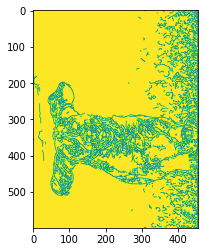

In [2]:
drawing = AutoDraw("./dog.jpeg")
commands = drawing.drawOutline()


In [11]:
print(commands)

[(20.833333333333332, 20.833333333333332), (182, 8), 'DOWN', (37.83333333333333, 20.833333333333332), (37.83333333333333, 20.833333333333332), (37.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (40.83333333333333, 20.833333333333332), (40.83333333333333, 21.833333333333332), (39.83333333333333, 21.833333333333332), 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', (40.83333333333333, 21.833333333333332), (40.83333333333333, 21.833333333333332), 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.8333333333333

In [10]:
cnc = CNC()
cnc.open("./test.gcode")

cnc.g90()
cnc.g0(z=5)
cnc.f(3000)
cnc.g1(z=0)
for command in commands:
    if command == 'UP':
        cnc.up()
    elif command == 'DOWN':
        cnc.down()
    else:
        cnc.g1(x=command[0],y=command[1])

cnc.close()

G90 
G0 Z5
F3000
G1 Z0
G1 X20.833333333333332 Y20.833333333333332
G1 X182 Y8
G1 Z0
G1 X37.83333333333333 Y20.833333333333332
G1 X37.83333333333333 Y20.833333333333332
G1 X37.83333333333333 Y20.833333333333332
G1 X38.83333333333333 Y20.833333333333332
G1 X38.83333333333333 Y20.833333333333332
G1 X38.83333333333333 Y20.833333333333332
G1 X39.83333333333333 Y20.833333333333332
G1 X39.83333333333333 Y20.833333333333332
G1 X39.83333333333333 Y20.833333333333332
G1 X40.83333333333333 Y20.833333333333332
G1 X40.83333333333333 Y21.833333333333332
G1 X39.83333333333333 Y21.833333333333332
G0 Z1
G1 X40.83333333333333 Y21.833333333333332
G1 Z0
G0 Z1
G1 X40.83333333333333 Y21.833333333333332
G1 Z0
G1 X40.83333333333333 Y21.833333333333332
G1 X40.83333333333333 Y21.833333333333332
G0 Z1
G1 X40.83333333333333 Y21.833333333333332
G1 Z0
G1 X41.83333333333333 Y21.833333333333332
G1 X41.83333333333333 Y21.833333333333332
G1 X41.83333333333333 Y21.833333333333332
G1 X41.83333333333333 Y21.833333333333332

G1 X66.83333333333333 Y29.833333333333332
G1 Z0
G0 Z1
G1 X66.83333333333333 Y29.833333333333332
G1 Z0
G0 Z1
G1 X66.83333333333333 Y29.833333333333332
G1 Z0
G0 Z1
G1 X65.83333333333333 Y29.833333333333332
G1 Z0
G0 Z1
G1 X65.83333333333333 Y29.833333333333332
G1 Z0
G0 Z1
G1 X65.83333333333333 Y29.833333333333332
G1 Z0
G1 X65.83333333333333 Y29.833333333333332
G0 Z1
G1 X64.83333333333333 Y29.833333333333332
G1 Z0
G1 X64.83333333333333 Y29.833333333333332
G1 X64.83333333333333 Y29.833333333333332
G1 X64.83333333333333 Y29.833333333333332
G0 Z1
G1 X64.83333333333333 Y28.833333333333332
G1 Z0
G1 X64.83333333333333 Y28.833333333333332
G0 Z1
G1 X63.83333333333333 Y28.833333333333332
G1 Z0
G1 X63.83333333333333 Y28.833333333333332
G1 X63.83333333333333 Y28.833333333333332
G1 X63.83333333333333 Y28.833333333333332
G0 Z1
G1 X63.83333333333333 Y28.833333333333332
G1 Z0
G0 Z1
G1 X63.83333333333333 Y29.833333333333332
G1 Z0
G1 X62.83333333333333 Y28.833333333333332
G1 X62.83333333333333 Y28.83333333

G1 X44.83333333333333 Y62.83333333333333
G1 X44.83333333333333 Y62.83333333333333
G1 X44.83333333333333 Y62.83333333333333
G0 Z1
G1 X44.83333333333333 Y62.83333333333333
G1 Z0
G1 X44.83333333333333 Y61.83333333333333
G1 X44.83333333333333 Y61.83333333333333
G1 X45.83333333333333 Y61.83333333333333
G1 X45.83333333333333 Y61.83333333333333
G1 X45.83333333333333 Y61.83333333333333
G1 X45.83333333333333 Y61.83333333333333
G1 X45.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y61.83333333333333
G1 X46.83333333333333 Y60.83333333333333
G1 X46.83333333333333 Y60.83333333333333
G1 X46.83333333333333 Y60.83333333333333
G1 X46.83333333333333 Y60.83333333333333
G1 X46.83333333333333 Y60.83333333333333
G0 Z1
G1 X46.83333333333333 Y59.83333333333333
G1 Z0
G1 X46.83333333333333 Y59.83333333333333
G1 X47.83333333333333 Y59.8333333

G1 X45.83333333333333 Y27.833333333333332
G1 X46.83333333333333 Y27.833333333333332
G0 Z1
G1 X46.83333333333333 Y26.833333333333332
G1 Z0
G1 X46.83333333333333 Y26.833333333333332
G0 Z1
G1 X46.83333333333333 Y26.833333333333332
G1 Z0
G1 X46.83333333333333 Y26.833333333333332
G1 X46.83333333333333 Y26.833333333333332
G0 Z1
G1 X46.83333333333333 Y26.833333333333332
G1 Z0
G1 X46.83333333333333 Y26.833333333333332
G1 X46.83333333333333 Y26.833333333333332
G1 X46.83333333333333 Y26.833333333333332
G1 X46.83333333333333 Y26.833333333333332
G0 Z1
G1 X46.83333333333333 Y25.833333333333332
G1 Z0
G1 X46.83333333333333 Y25.833333333333332
G0 Z1
G1 X46.83333333333333 Y25.833333333333332
G1 Z0
G1 X46.83333333333333 Y25.833333333333332
G1 X47.83333333333333 Y25.833333333333332
G1 X47.83333333333333 Y25.833333333333332
G1 X47.83333333333333 Y25.833333333333332
G1 X47.83333333333333 Y25.833333333333332
G1 X46.83333333333333 Y24.833333333333332
G1 X46.83333333333333 Y25.833333333333332
G1 X46.833333333

G1 X57.83333333333333 Y40.83333333333333
G1 Z0
G1 X57.83333333333333 Y40.83333333333333
G1 X58.83333333333333 Y40.83333333333333
G0 Z1
G1 X58.83333333333333 Y39.83333333333333
G1 Z0
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y39.83333333333333
G1 X58.83333333333333 Y40.83333333333333
G1 X58.83333333333333 Y40.83333333333333
G0 Z1
G1 X58.83333333333333 Y40.83333333333333
G1 Z0
G0 Z1
G1 X59.83333333333333 Y40.83333333333333
G1 Z0
G0 Z1
G1 X59.83333333333333 Y39.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y39.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y39.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y39.83333333333333
G1 Z0
G0 Z1
G1 X59.83333333333333 Y39.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y38.83333333333333
G1 Z0
G0 Z1
G1 X58.833333333333

G1 X57.83333333333333 Y63.83333333333333
G1 X57.83333333333333 Y63.83333333333333
G1 X57.83333333333333 Y63.83333333333333
G1 X57.83333333333333 Y63.83333333333333
G0 Z1
G1 X58.83333333333333 Y63.83333333333333
G1 Z0
G1 X58.83333333333333 Y63.83333333333333
G0 Z1
G1 X58.83333333333333 Y63.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y63.83333333333333
G1 Z0
G1 X58.83333333333333 Y63.83333333333333
G0 Z1
G1 X58.83333333333333 Y63.83333333333333
G1 Z0
G0 Z1
G1 X58.83333333333333 Y63.83333333333333
G1 Z0
G0 Z1
G1 X59.83333333333333 Y63.83333333333333
G1 Z0
G1 X59.83333333333333 Y63.83333333333333
G1 X59.83333333333333 Y62.83333333333333
G0 Z1
G1 X59.83333333333333 Y62.83333333333333
G1 Z0
G1 X59.83333333333333 Y62.83333333333333
G1 X59.83333333333333 Y62.83333333333333
G1 X59.83333333333333 Y62.83333333333333
G1 X59.83333333333333 Y62.83333333333333
G1 X59.83333333333333 Y62.83333333333333
G1 X60.83333333333333 Y62.83333333333333
G1 X60.83333333333333 Y61.83333333333333
G0 Z1
G1 X60.8

G1 X23.833333333333332 Y62.83333333333333
G1 X23.833333333333332 Y62.83333333333333
G0 Z1
G1 X23.833333333333332 Y62.83333333333333
G1 Z0
G0 Z1
G1 X24.833333333333332 Y63.83333333333333
G1 Z0
G0 Z1
G1 X24.833333333333332 Y63.83333333333333
G1 Z0
G0 Z1
G1 X24.833333333333332 Y62.83333333333333
G1 Z0
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G0 Z1
G1 X24.833333333333332 Y62.83333333333333
G1 Z0
G0 Z1
G1 X24.833333333333332 Y62.83333333333333
G1 Z0
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G0 Z1
G1 X24.833333333333332 Y62.83333333333333
G1 Z0
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.83333333333333
G1 X24.833333333333332 Y62.8333333

G1 X39.83333333333333 Y57.83333333333333
G1 X39.83333333333333 Y57.83333333333333
G0 Z1
G1 X39.83333333333333 Y57.83333333333333
G1 Z0
G1 X39.83333333333333 Y57.83333333333333
G0 Z1
G1 X39.83333333333333 Y57.83333333333333
G1 Z0
G1 X39.83333333333333 Y57.83333333333333
G0 Z1
G1 X39.83333333333333 Y57.83333333333333
G1 Z0
G1 X40.83333333333333 Y58.83333333333333
G1 X40.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G1 X39.83333333333333 Y58.83333333333333
G0 Z1
G1 X38.83333333333333 Y58.83333333333333
G1 Z0
G0 Z1
G1 

G1 Z0
G0 Z1
G1 X53.83333333333333 Y51.83333333333333
G1 Z0
G0 Z1
G1 X54.83333333333333 Y51.83333333333333
G1 Z0
G0 Z1
G1 X54.83333333333333 Y51.83333333333333
G1 Z0
G1 X54.83333333333333 Y51.83333333333333
G0 Z1
G1 X54.83333333333333 Y52.83333333333333
G1 Z0
G1 X54.83333333333333 Y52.83333333333333
G1 X54.83333333333333 Y52.83333333333333
G0 Z1
G1 X54.83333333333333 Y53.83333333333333
G1 Z0
G1 X54.83333333333333 Y53.83333333333333
G0 Z1
G1 X53.83333333333333 Y53.83333333333333
G1 Z0
G1 X53.83333333333333 Y53.83333333333333
G1 X53.83333333333333 Y53.83333333333333
G1 X53.83333333333333 Y53.83333333333333
G0 Z1
G1 X53.83333333333333 Y52.83333333333333
G1 Z0
G1 X53.83333333333333 Y52.83333333333333
G0 Z1
G1 X55.83333333333333 Y54.83333333333333
G1 Z0
G1 X56.83333333333333 Y54.83333333333333
G1 X56.83333333333333 Y54.83333333333333
G1 X56.83333333333333 Y54.83333333333333
G1 X56.83333333333333 Y54.83333333333333
G1 X56.83333333333333 Y54.83333333333333
G1 X56.83333333333333 Y54.83333333333

G1 X76.83333333333333 Y62.83333333333333
G0 Z1
G1 X76.83333333333333 Y62.83333333333333
G1 Z0
G1 X76.83333333333333 Y62.83333333333333
G1 X76.83333333333333 Y62.83333333333333
G1 X76.83333333333333 Y62.83333333333333
G1 X76.83333333333333 Y62.83333333333333
G1 X76.83333333333333 Y62.83333333333333
G1 X76.83333333333333 Y62.83333333333333
G0 Z1
G1 X75.83333333333333 Y62.83333333333333
G1 Z0
G1 X75.83333333333333 Y62.83333333333333
G1 X75.83333333333333 Y62.83333333333333
G1 X75.83333333333333 Y62.83333333333333
G1 X75.83333333333333 Y62.83333333333333
G1 X75.83333333333333 Y62.83333333333333
G1 X75.83333333333333 Y63.83333333333333
G1 X75.83333333333333 Y63.83333333333333
G1 X75.83333333333333 Y63.83333333333333
G0 Z1
G1 X75.83333333333333 Y63.83333333333333
G1 Z0
G1 X75.83333333333333 Y63.83333333333333
G1 X75.83333333333333 Y63.83333333333333
G0 Z1
G1 X75.83333333333333 Y63.83333333333333
G1 Z0
G1 X74.83333333333333 Y63.83333333333333
G1 X74.83333333333333 Y63.83333333333333
G1 X74.83

G0 Z1
G1 X64.83333333333333 Y54.83333333333333
G1 Z0
G1 X64.83333333333333 Y54.83333333333333
G1 X64.83333333333333 Y54.83333333333333
G0 Z1
G1 X64.83333333333333 Y54.83333333333333
G1 Z0
G0 Z1
G1 X64.83333333333333 Y55.83333333333333
G1 Z0
G1 X64.83333333333333 Y55.83333333333333
G0 Z1
G1 X65.83333333333333 Y55.83333333333333
G1 Z0
G0 Z1
G1 X65.83333333333333 Y54.83333333333333
G1 Z0
G0 Z1
G1 X65.83333333333333 Y54.83333333333333
G1 Z0
G0 Z1
G1 X65.83333333333333 Y54.83333333333333
G1 Z0
G0 Z1
G1 X64.83333333333333 Y54.83333333333333
G1 Z0
G1 X64.83333333333333 Y54.83333333333333
G1 X64.83333333333333 Y54.83333333333333
G1 X64.83333333333333 Y54.83333333333333
G1 X64.83333333333333 Y54.83333333333333
G0 Z1
G1 X64.83333333333333 Y53.83333333333333
G1 Z0
G1 X64.83333333333333 Y53.83333333333333
G1 X64.83333333333333 Y53.83333333333333
G1 X64.83333333333333 Y53.83333333333333
G1 X64.83333333333333 Y53.83333333333333
G0 Z1
G1 X65.83333333333333 Y53.83333333333333
G1 Z0
G0 Z1
G1 X64.833333